In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import aesara.tensor as at
import matplotlib.pyplot as plt
from util import build_XY

In [2]:
# set the seed
np.random.seed(123)

In [3]:
df = pd.read_csv("../data/fastball_spin_rates_2021.csv")
df.shape

(4845, 4)

In [4]:
df.columns

Index(['pitcher_name', 'game_date', 'avg_spin_rate', 'n_pitches'], dtype='object')

In [5]:
df.head()

,pitcher_name,game_date,avg_spin_rate,n_pitches
0,"Wainwright, Adam",2021-04-03,2127.415000,12
1,"Wainwright, Adam",2021-04-08,2179.723000,11
2,"Wainwright, Adam",2021-04-14,2297.968571,7
3,"Wainwright, Adam",2021-04-20,2159.150000,13
4,"Wainwright, Adam",2021-04-26,2314.515455,11


In [6]:
df.isna().sum()

pitcher_name     0
game_date        0
avg_spin_rate    7
n_pitches        0
dtype: int64

In [7]:
df['pitcher_name'].nunique(), df['game_date'].nunique()

(262, 182)

In [8]:
df["avg_spin_rate"].describe()

count    4838.000000
mean     2262.381625
std       169.895006
min      1642.870000
25%      2146.792611
50%      2263.186250
75%      2378.541008
max      2899.950000
Name: avg_spin_rate, dtype: float64

### Top N pitchers

In [9]:
# Get tip pitchers by attending most games
n_outputs = 5 # Top 5 pitchers
top_pitchers = df.groupby("pitcher_name")["game_date"].count().nlargest(n_outputs).reset_index()
top_pitchers = top_pitchers.reset_index().rename(columns={"index":"output_idx"})
top_pitchers

,output_idx,pitcher_name,game_date
0,0,"Rodriguez, Richard",64
1,1,"Taylor, Josh",59
2,2,"Kopech, Michael",43
3,3,"Wells, Tyler",43
4,4,"Hearn, Taylor",42


In [10]:
adf = df.loc[df["pitcher_name"].isin(top_pitchers["pitcher_name"])]
adf.shape

(251, 4)

In [11]:
adf.head()

,pitcher_name,game_date,avg_spin_rate,n_pitches
1631,"Rodriguez, Richard",2021-04-01,2473.908333,12
1632,"Rodriguez, Richard",2021-04-06,2607.656667,3
1633,"Rodriguez, Richard",2021-04-08,2579.757000,10
1634,"Rodriguez, Richard",2021-04-12,2568.509286,14
1635,"Rodriguez, Richard",2021-04-13,2588.001111,9


In [12]:
adf["avg_spin_rate"].describe()

count     251.000000
mean     2393.891321
std       147.385561
min      2083.833333
25%      2279.867500
50%      2357.402692
75%      2520.131707
max      2712.219500
Name: avg_spin_rate, dtype: float64

In [13]:
# Standardise output
adf["avg_spin_rate"] = (adf["avg_spin_rate"] - adf["avg_spin_rate"].mean())/adf["avg_spin_rate"].std()
adf["avg_spin_rate"].describe()

/tmp/ipykernel_13809/461542218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adf["avg_spin_rate"] = (adf["avg_spin_rate"] - adf["avg_spin_rate"].mean())/adf["avg_spin_rate"].std()


count    2.510000e+02
mean    -2.172675e-15
std      1.000000e+00
min     -2.103720e+00
25%     -7.736431e-01
50%     -2.475726e-01
75%      8.565316e-01
max      2.159833e+00
Name: avg_spin_rate, dtype: float64

### Create a date index

In [14]:
adf.loc[:,"game_date"] = pd.to_datetime(adf["game_date"])

/tmp/ipykernel_13809/3223010944.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adf.loc[:,"game_date"] = pd.to_datetime(adf["game_date"])


In [15]:
gdates = adf["game_date"]

In [16]:
gdates.min(), gdates.max(), gdates.nunique(), (gdates.max() - gdates.min())

(Timestamp('2021-04-01 00:00:00'),
 Timestamp('2021-10-03 00:00:00'),
 142,
 Timedelta('185 days 00:00:00'))

In [17]:
dates_idx = pd.DataFrame({"game_date":pd.date_range(gdates.min(), gdates.max())}).reset_index()
dates_idx = dates_idx.rename(columns={"index":"x"})
dates_idx.head()

,x,game_date
0,0,2021-04-01
1,1,2021-04-02
2,2,2021-04-03
3,3,2021-04-04
4,4,2021-04-05


### Create training data

In [18]:
adf = adf.merge(dates_idx, how="left", on="game_date")
adf = adf.merge(top_pitchers[["pitcher_name", "output_idx"]], how="left", on="pitcher_name")
adf.head()

,pitcher_name,game_date,avg_spin_rate,n_pitches,x,output_idx
0,"Rodriguez, Richard",2021-04-01,0.542909,12,0,0
1,"Rodriguez, Richard",2021-04-06,1.450382,3,5,0
2,"Rodriguez, Richard",2021-04-08,1.261085,10,7,0
3,"Rodriguez, Richard",2021-04-12,1.184770,14,11,0
4,"Rodriguez, Richard",2021-04-13,1.317020,9,12,0


In [19]:
adf = adf.sort_values(["output_idx", "x"])
X = adf[["x", "output_idx"]].values
Y = adf["avg_spin_rate"].values
X.shape, Y.shape

((251, 2), (251,))

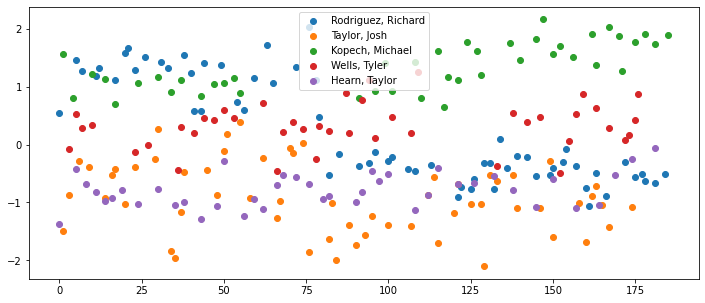

In [20]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
legends = []
for pitcher in top_pitchers["pitcher_name"]:
    cond = adf["pitcher_name"] == pitcher
    ax.scatter(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"])
    legends.append(pitcher)
plt.legend(legends)

### GP model with ICM

In [21]:
def get_icm(input_dim, kernel, W=None, kappa=None, B=None, active_dims=None, name='ICM'):
    coreg = pm.gp.cov.Coregion(input_dim=input_dim, W=W, kappa=kappa, B=B, active_dims=active_dims)
    icm_cov = kernel * coreg # Seperate input => Use Hadamard Product
    return icm_cov

In [22]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    kernel = pm.gp.cov.ExpQuad(input_dim=2, ls=ell, active_dims=[0])
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Get ICM kernel
    W = pm.Normal("W", mu=0, sigma=3, shape=(n_outputs,2), initval=np.random.randn(n_outputs,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=n_outputs)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    
    cov_icm = get_icm(input_dim=2, kernel=kernel, B=B, active_dims=[1])

    # Define a Multi-output GP 
    mogp = pm.gp.Marginal(cov_func=cov_icm)
    y_ = mogp.marginal_likelihood("f", X, Y, noise=sigma)    

In [23]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, W, kappa]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 288 seconds.


CPU times: user 13min 46s, sys: 24min 4s, total: 37min 50s
Wall time: 4min 52s


In [24]:
M = 200
x_new = np.linspace(0, 200, M)[:, None]
X_new, _, _ = build_XY([x_new for idx in range(n_outputs)])
X_new.shape

(1000, 2)

In [25]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 11min 25s, sys: 8min 39s, total: 20min 4s
Wall time: 2min 35s


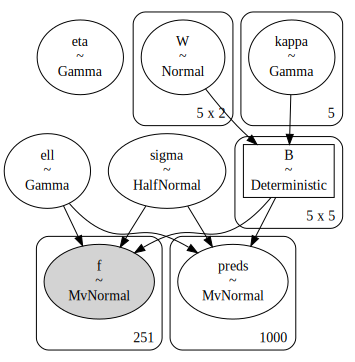

In [26]:
pm.model_to_graphviz(model)

In [27]:
top_pitchers["pitcher_name"]

0    Rodriguez, Richard
1          Taylor, Josh
2       Kopech, Michael
3          Wells, Tyler
4         Hearn, Taylor
Name: pitcher_name, dtype: object

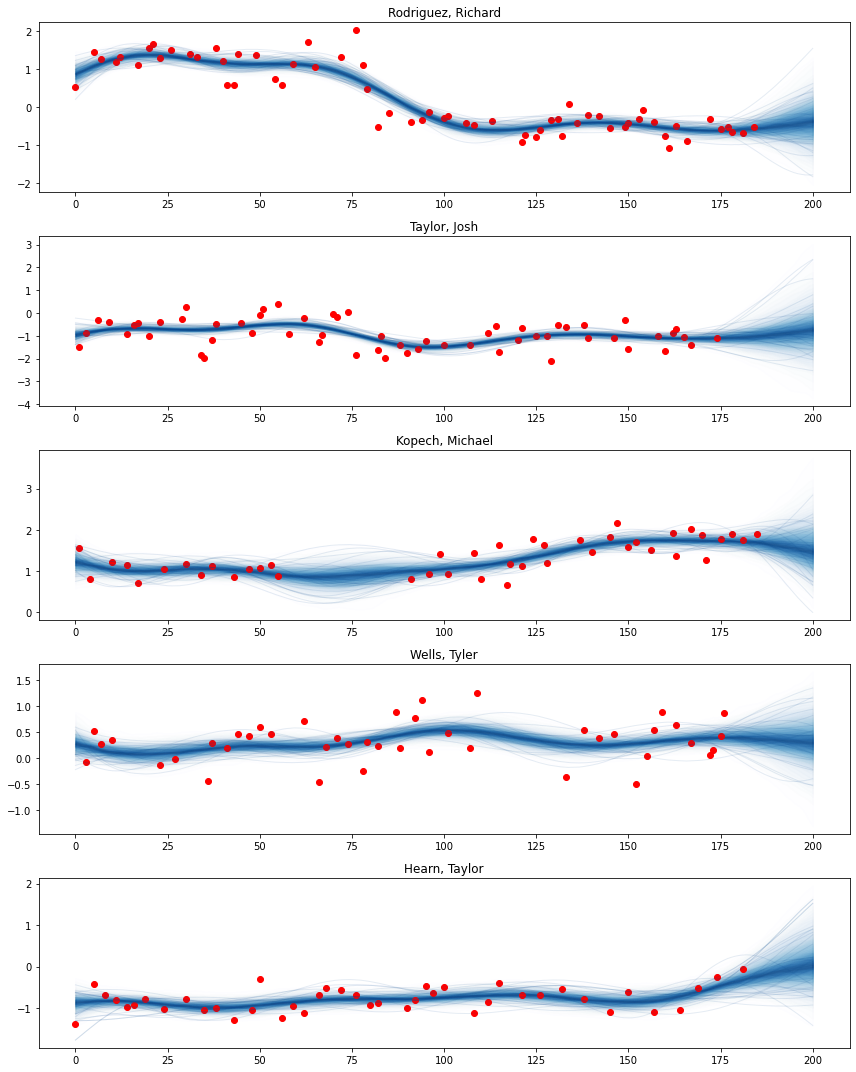

In [28]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(n_outputs,1, figsize=(12,15))

for idx, pitcher in enumerate(top_pitchers["pitcher_name"]):
    # Prediction
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.1, samples_alpha=0.1)    
    # Train data points
    cond = adf["pitcher_name"] == pitcher
    axes[idx].scatter(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"], color='r')
    axes[idx].set_title(pitcher)
plt.tight_layout()

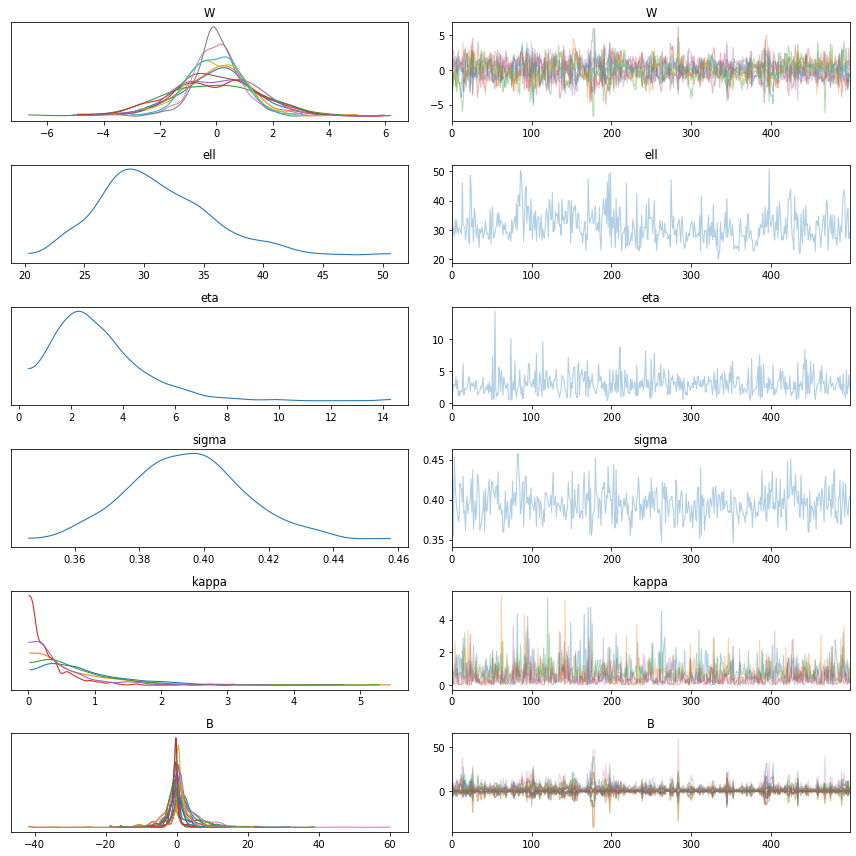

In [29]:
az.plot_trace(gp_trace);
plt.tight_layout()

### GP model with LCM (2 or more kernels)

In [30]:
def get_lcm(input_dim, active_dims, num_outputs, kernels, W=None, B=None, name='ICM'):
    if B is None:
        kappa = pm.Gamma(f"{name}_kappa", alpha=5, beta=1, shape=num_outputs)
        if W is None:
            W = pm.Normal(f"{name}_W", mu=0, sigma=5, shape=(num_outputs, 1), 
                                                        initval=np.random.randn(num_outputs, 1))
    else:
        kappa = None

    cov_func = 0
    for idx, kernel in enumerate(kernels):            
        icm = get_icm(input_dim, kernel, W, kappa, B, active_dims, f'{name}_{idx}')
        cov_func += icm
    return cov_func

In [31]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(input_dim=2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in enumerate(kernels)]
    
    # Define a Multi-output GP 
    cov_lcm = get_lcm(input_dim=2, active_dims=[1], num_outputs=n_outputs, kernels=cov_list)
    
    mogp = pm.gp.Marginal(cov_func=cov_lcm)
    y_ = mogp.marginal_likelihood("f", X, Y, noise=sigma)    

In [32]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_kappa, ICM_W]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 340 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 16min 27s, sys: 28min 42s, total: 45min 10s
Wall time: 5min 47s


In [33]:
M = 200
x_new = np.linspace(0, 200, M)[:, None]
X_new, _, _ = build_XY([x_new for idx in range(n_outputs)])
X_new.shape

(1000, 2)

In [34]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 13min 13s, sys: 11min 48s, total: 25min 1s
Wall time: 3min 19s


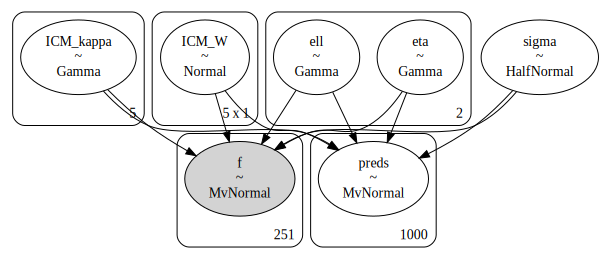

In [35]:
pm.model_to_graphviz(model)

In [36]:
top_pitchers["pitcher_name"]

0    Rodriguez, Richard
1          Taylor, Josh
2       Kopech, Michael
3          Wells, Tyler
4         Hearn, Taylor
Name: pitcher_name, dtype: object

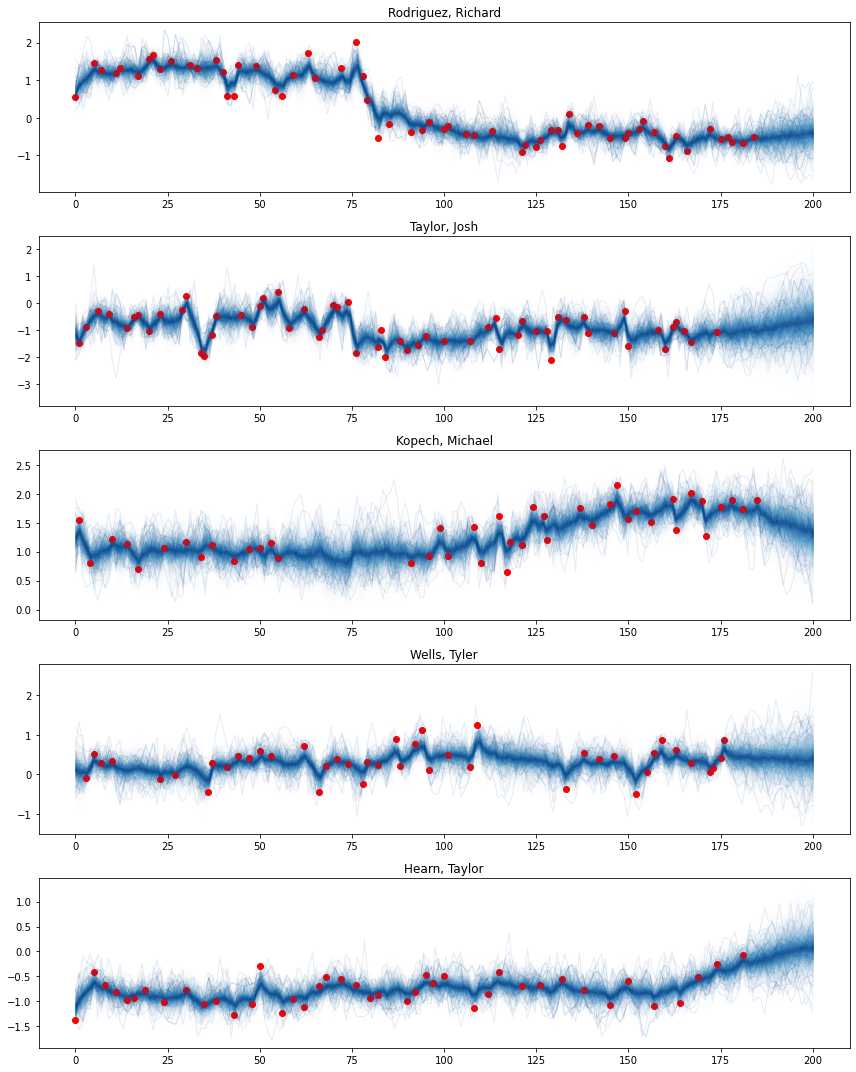

In [37]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(n_outputs,1, figsize=(12,15))

for idx, pitcher in enumerate(top_pitchers["pitcher_name"]):
    # Prediction
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.1, samples_alpha=0.1)    
    # Train data points
    cond = adf["pitcher_name"] == pitcher
    axes[idx].scatter(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"], color='r')
    axes[idx].set_title(pitcher)
plt.tight_layout()

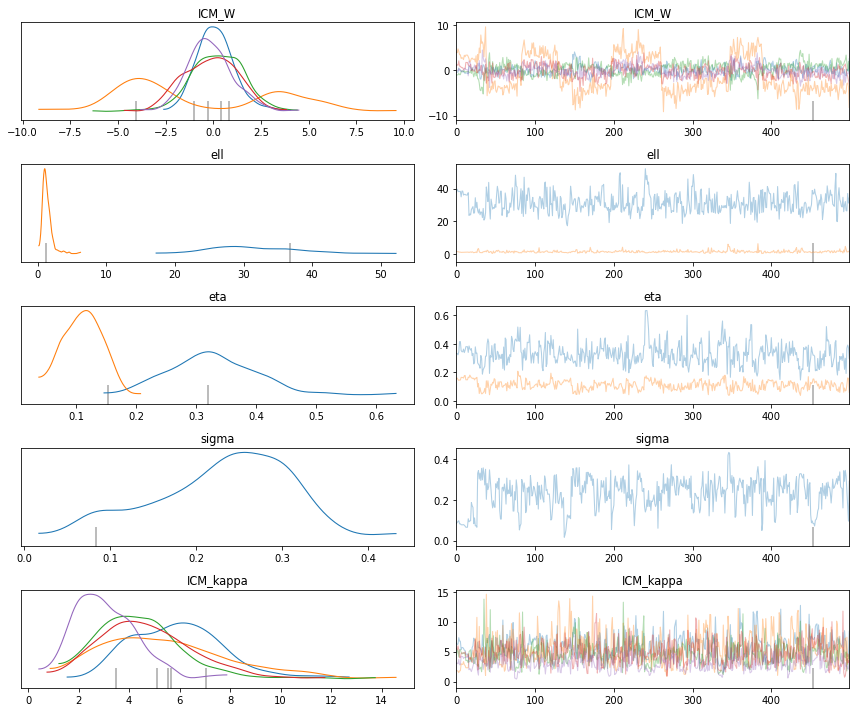

In [38]:
az.plot_trace(gp_trace);
plt.tight_layout()

### Add Periodic kernel to Covariance List

In [39]:
with pm.Model() as model:
    # Priors
    ell = pm.Gamma("ell", alpha=2, beta=0.5, shape=2)
    eta = pm.Gamma("eta", alpha=3, beta=1, shape=2)
    kernels = [pm.gp.cov.ExpQuad, pm.gp.cov.Matern32]
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    # Define a list of covariance functions
    cov_list = [eta[idx] ** 2 * kernel(input_dim=2,ls=ell[idx], active_dims=[0]) 
                for idx, kernel in enumerate(kernels)]
    
    # Add a Periodic kernel
    cov_period = pm.gp.cov.Periodic(input_dim=2, period=28, ls=2, active_dims=[1])
    cov_list.append(cov_period)
    
    # Define a Multi-output GP 
    cov_lcm = get_lcm(input_dim=2, active_dims=[1], num_outputs=n_outputs, kernels=cov_list)
    
    mogp = pm.gp.Marginal(cov_func=cov_lcm)    
    y_ = mogp.marginal_likelihood("f", X, Y, noise=sigma)    

In [40]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, sigma, ICM_kappa, ICM_W]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 388 seconds.


CPU times: user 16min 58s, sys: 31min 42s, total: 48min 40s
Wall time: 6min 36s


In [41]:
M = 200
x_new = np.linspace(0, 200, M)[:, None]
X_new, _, _ = build_XY([x_new for idx in range(n_outputs)])
X_new.shape

(1000, 2)

In [42]:
%%time
with model:
    preds = mogp.conditional("preds", X_new)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'], random_seed=42)

CPU times: user 13min 18s, sys: 13min 34s, total: 26min 52s
Wall time: 3min 44s


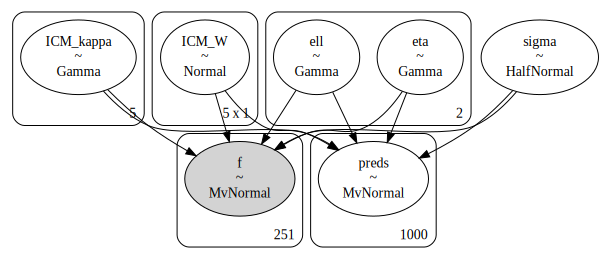

In [43]:
pm.model_to_graphviz(model)

In [44]:
top_pitchers["pitcher_name"]

0    Rodriguez, Richard
1          Taylor, Josh
2       Kopech, Michael
3          Wells, Tyler
4         Hearn, Taylor
Name: pitcher_name, dtype: object

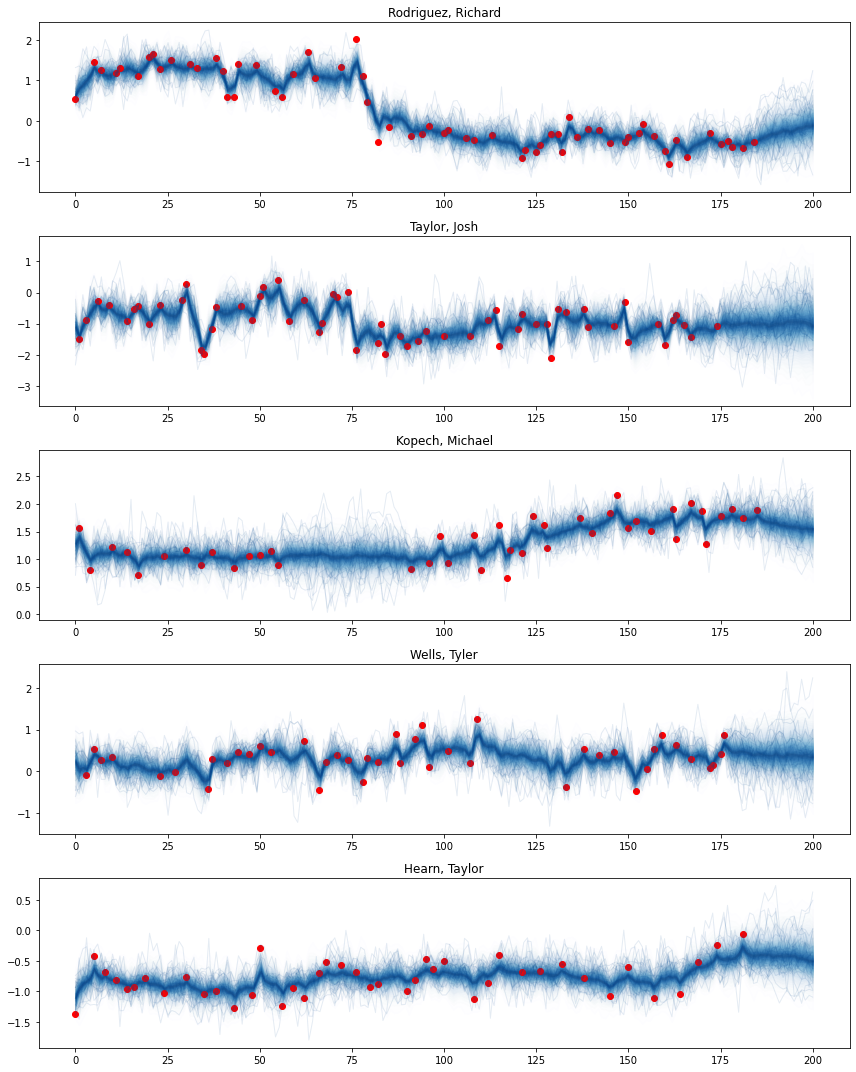

In [45]:
from pymc.gp.util import plot_gp_dist

f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
fig, axes = plt.subplots(n_outputs,1, figsize=(12,15))

for idx, pitcher in enumerate(top_pitchers["pitcher_name"]):
    # Prediction
    plot_gp_dist(axes[idx], f_pred[:,M*idx:M*(idx+1)], 
                 X_new[M*idx:M*(idx+1),0], 
                 palette="Blues", fill_alpha=0.1, samples_alpha=0.1)    
    # Train data points
    cond = adf["pitcher_name"] == pitcher
    axes[idx].scatter(adf.loc[cond, "x"], adf.loc[cond, "avg_spin_rate"], color='r')
    axes[idx].set_title(pitcher)
plt.tight_layout()

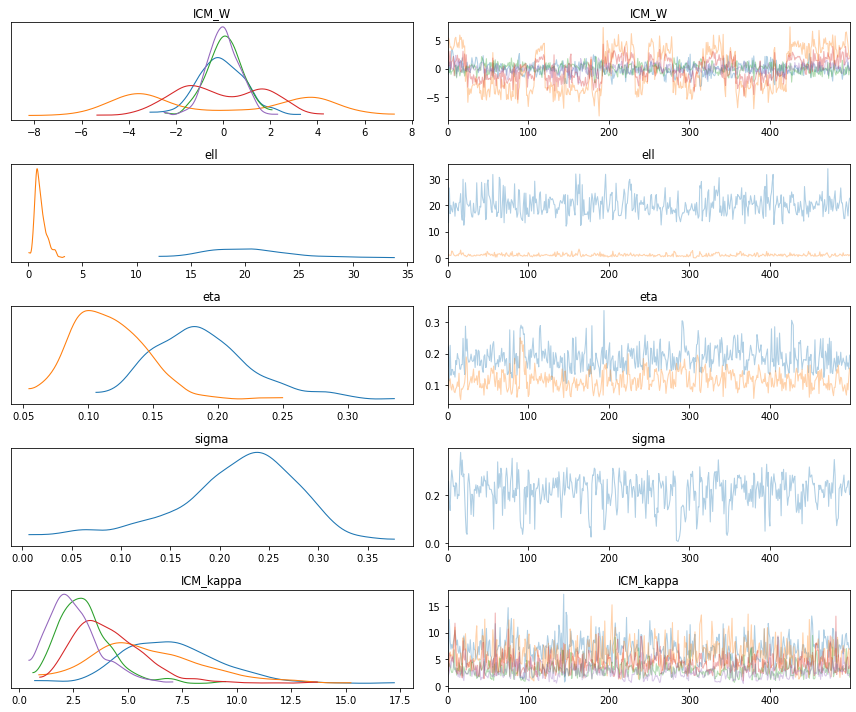

In [46]:
az.plot_trace(gp_trace);
plt.tight_layout()